# Classifier Evaluation Notebook

This notebook evaluates multiple trained image classification models on pre-cropped animal images.  
It covers both **multi-model evaluation** (ConvNeXt, EfficientNet-V2-S, and CBAM-enhanced variants) and a **detailed ConvNeXt fine-tuned model analysis**.

## Main Steps
1. **Model Definitions & Loading**
   - Defines custom PyTorch architectures:
     - `ConvNeXtClassifier`
     - `EffNetPlain` (EfficientNet-V2-S with single CBAM)
     - `CBAMEffNet3` (EfficientNet-V2-S with CBAM after last three stages)
   - Loads model checkpoints along with their class label mappings.

2. **Evaluation on GT Crops**
   - Runs all models on four dataset splits: `cis_val`, `cis_test`, `trans_val`, `trans_test`.
   - Calculates accuracy, precision, recall, F1-score (macro-averaged).
   - Generates and saves **normalized confusion matrices**.
   - Summarizes results into `classifier_stage/summary_metrics.csv`.

3. **Fine-Grained ConvNeXt Analysis**
   - Loads a fine-tuned ConvNeXt model.
   - Evaluates on validation crops with **Top-1** and **Top-3** accuracy.
   - Computes per-class statistics, confidence distributions, and false-positive analysis.
   - Saves merged prediction CSV (`val_cls_merged.csv`) for deeper review.

4. **Background Class Confidence Review**
   - Checks model predictions on background-labeled crops.
   - Groups by **confidence bins** (high, mid, low) to inspect possible mislabels or missed detections.
   - Visualizes high-confidence background predictions for manual inspection.

5. **Confidence Thresholding Experiment**
   - Applies a decision threshold (e.g., 0.55) to classify low-confidence predictions as "background".
   - Recalculates metrics after thresholding to assess impact on accuracy and false positives.

6. **ONNX Export**
   - Exports the fine-tuned ConvNeXt model to ONNX format for deployment.

## Purpose
This notebook helps **compare classifier architectures**, **understand error patterns**, and **explore post-processing strategies** (like thresholding) before integration into the full wildlife detection pipeline.


In [ ]:
# ────────────────────────────────────────────────────────────
# 0. Imports & paths
# ────────────────────────────────────────────────────────────
import torch, timm, numpy as np, pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from datetime import datetime
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from timm.layers.cbam import CbamModule
import cv2

OUT_DIR = Path("classifier_stage"); OUT_DIR.mkdir(exist_ok=True, parents=True)

WEIGHTS = {
    "convnext_classaware"          : "../scripts/train/convnext_classaware/best_model.pth",
    "efficientnet_v2_s"            : "../scripts/train/efficientnet_v2_s/best_model.pth",
    "efficientnet_v2_s_classaware" : "../scripts/train/efficientnet_v2_s_classaware/best_model.pth",
}

SPLITS = [
    ("../data/crops_gt/trans_val",  "trans", "val"),
    ("../data/crops_gt/trans_test", "trans", "test"),
    ("../data/crops_gt/cis_val",    "cis",   "val"),
    ("../data/crops_gt/cis_test",   "cis",   "test"),
]

# ────────────────────────────────────────────────────────────
# 1. Generic helpers
# ────────────────────────────────────────────────────────────
def get_block_channels(block):
    if hasattr(block, "conv_pwl"): return block.conv_pwl.out_channels
    if hasattr(block, "conv4"):    return block.conv4.out_channels
    raise RuntimeError("Unknown block structure")

# ────────────────────────────────────────────────────────────
# 2. Model definitions
# ────────────────────────────────────────────────────────────
class ConvNeXtClassifier(nn.Module):
    def __init__(self, n_cls, dropout=0.5):
        super().__init__()
        self.backbone = timm.create_model(
            "convnext_small", pretrained=False, features_only=True)
        feat = self.backbone.feature_info[-1]["num_chs"]
        self.pool = nn.AdaptiveAvgPool2d(1)

        # ← KEEP THE NAME “classifier”
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, 256),  nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, n_cls)
        )

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = self.pool(x)
        return self.classifier(x)

class EffNetPlain(nn.Module):
    "EfficientNet-V2-S, single CBAM."
    def __init__(self, n_cls, dropout=0.2):
        super().__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_s",
                                          pretrained=False, num_classes=0)
        # Single CBAM instead of ModuleDict
        self.cbam = CbamModule(self.backbone.num_features)  # or appropriate channels
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(self.backbone.num_features, n_cls)
    def forward(self, x):
        x = self.backbone.conv_stem(x); x = self.backbone.bn1(x)
        for stage in self.backbone.blocks:
            x = stage(x)
        x = self.backbone.conv_head(x); x = self.backbone.bn2(x)
        x = self.cbam(x)  # Apply CBAM after all backbone processing
        x = self.drop(self.pool(x).flatten(1))
        return self.head(x)

class CBAMEffNet3(nn.Module):
    "EfficientNet-V2-S with CBAM after the last three stages."
    def __init__(self, n_cls, dropout=0.2):
        super().__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_s",
                                          pretrained=False, num_classes=0)
        stages = len(self.backbone.blocks)
        idxs   = [stages-3, stages-2, stages-1]
        self.cbams = nn.ModuleDict({str(i): CbamModule(
            get_block_channels(self.backbone.blocks[i][-1])) for i in idxs})
        self.pool = nn.AdaptiveAvgPool2d(1); self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(self.backbone.num_features, n_cls)
    def forward(self, x):
        x = self.backbone.conv_stem(x); x = self.backbone.bn1(x)
        for i,stage in enumerate(self.backbone.blocks):
            x = stage(x)
            if str(i) in self.cbams: x = self.cbams[str(i)](x)
        x = self.backbone.conv_head(x); x = self.backbone.bn2(x)
        x = self.drop(self.pool(x).flatten(1))
        return self.head(x)

# ────────────────────────────────────────────────────────────
# 3. Loader functions
# ────────────────────────────────────────────────────────────
def load_ckpt(path, arch_cls):
    ckpt = torch.load(path, map_location="cpu")
    classes = ckpt["class_names"]
    net = arch_cls(len(classes)); net.load_state_dict(ckpt["model_state_dict"])
    return net.eval().cuda(), classes

LOADERS = {
    "convnext_classaware"          : lambda p: load_ckpt(p, ConvNeXtClassifier),
    "efficientnet_v2_s"            : lambda p: load_ckpt(p, EffNetPlain,),
    "efficientnet_v2_s_classaware" : lambda p: load_ckpt(p, CBAMEffNet3),
}

# ────────────────────────────────────────────────────────────
# 4. Confusion-matrix helper
# ────────────────────────────────────────────────────────────
def save_cm(cm, names, tag):
    cm_norm = cm.astype(float) / cm.sum(1, keepdims=True)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm_norm, cmap="Blues", xticklabels=names, yticklabels=names, 
                annot=True, fmt='.2f', ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); fig.tight_layout()
    out = OUT_DIR / f"{tag}_cm.png"; fig.savefig(out, dpi=300); plt.close(fig)
    return out.name

# ────────────────────────────────────────────────────────────
# 5. Evaluation loop
# ────────────────────────────────────────────────────────────
tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
BATCH = 64
cache, rows = {}, []

for mname, wpath in WEIGHTS.items():
    for root, dom, spl in SPLITS:
        ds = datasets.ImageFolder(root, transform=tfm)
        dl = DataLoader(ds, BATCH, shuffle=False, num_workers=4)

        if mname not in cache:
            cache[mname] = LOADERS[mname](wpath)
        net, m_classes = cache[mname]

        m2d = {mi: ds.classes.index(c)
               for mi, c in enumerate(m_classes) if c in ds.classes}

        ys, ps = [], []
        with torch.no_grad():
            for x, y in dl:
                pred = net(x.cuda()).argmax(1).cpu()
                ps.append(torch.tensor([m2d.get(i.item(), -1) for i in pred]))
                ys.append(y)
        y_true = torch.cat(ys).numpy()
        y_pred = torch.cat(ps).numpy()
        keep   = y_pred != -1
        y_true, y_pred = y_true[keep], y_pred[keep]

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="macro", zero_division=0)
        acc = float((y_true == y_pred).mean())
        cm_png = save_cm(confusion_matrix(y_true, y_pred,
                            labels=range(len(ds.classes))),
                         ds.classes, f"{mname}_{dom}_{spl}") if len(y_true) else "no_data.png"
        rows.append(dict(model=mname, domain=dom, split=spl,
                         precision=prec, recall=rec, F1=f1, acc=acc,
                         cm_png=cm_png,
                         eval_time=datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
        print(f"{mname:<28} {dom}_{spl}: acc={acc:.3f}  F1={f1:.3f}  n={len(y_true)}")

# ────────────────────────────────────────────────────────────
# 6. Save summary CSV
# ────────────────────────────────────────────────────────────
pd.DataFrame(rows).to_csv(OUT_DIR/"summary_metrics.csv", index=False)
print("✓ Metrics written to classifier_stage/summary_metrics.csv")


C:\Users\cilek\AppData\Local\Temp\ipykernel_47852\100927801.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")


convnext_classaware          trans_val: acc=0.840  F1=0.652  n=1847
convnext_classaware          trans_test: acc=0.862  F1=0.714  n=16621
convnext_classaware          cis_val: acc=0.944  F1=0.864  n=1742
convnext_classaware          cis_test: acc=0.933  F1=0.840  n=11817


C:\Users\cilek\AppData\Local\Temp\ipykernel_47852\100927801.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")


efficientnet_v2_s            trans_val: acc=0.771  F1=0.576  n=1847
efficientnet_v2_s            trans_test: acc=0.796  F1=0.650  n=16614
efficientnet_v2_s            cis_val: acc=0.909  F1=0.838  n=1742
efficientnet_v2_s            cis_test: acc=0.869  F1=0.813  n=11817


C:\Users\cilek\AppData\Local\Temp\ipykernel_47852\100927801.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")


efficientnet_v2_s_classaware trans_val: acc=0.777  F1=0.549  n=1847
efficientnet_v2_s_classaware trans_test: acc=0.817  F1=0.638  n=16622
efficientnet_v2_s_classaware cis_val: acc=0.935  F1=0.836  n=1742
efficientnet_v2_s_classaware cis_test: acc=0.907  F1=0.789  n=11817
✓ Metrics written to classifier_stage/summary_metrics.csv


In [18]:
import json
import pandas as pd

with open("../data/crops_gt/val/val_manifest.json", "r") as f:
    manifest = json.load(f)

# Fix paths and flatten
for entry in manifest:
    entry["crop_path"] = entry["crop_path"].replace("\\", "/").replace("../../data", "../data")

# Convert to DataFrame
df_gt = pd.DataFrame(manifest)

# Extract filename and class
df_gt["filename"] = df_gt["crop_path"].apply(lambda p: p.split("/")[-1])
df_gt["true_class"] = df_gt["species"]

# Save for later merging
df_gt[["filename", "true_class"]].to_csv("val_gt_metadata.csv", index=False)


In [ ]:
import torch, timm, numpy as np, pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from datetime import datetime
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from timm.layers.cbam import CbamModule
from tqdm import tqdm
import os
from PIL import Image


class ConvNeXtClassifier(nn.Module):
    def __init__(self, n_cls, dropout=0.5):
        super().__init__()
        self.backbone = timm.create_model(
            "convnext_small", pretrained=False, features_only=True)
        feat = self.backbone.feature_info[-1]["num_chs"]
        self.pool = nn.AdaptiveAvgPool2d(1)

        # ← KEEP THE NAME “classifier”
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, 256),  nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, n_cls)
        )

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = self.pool(x)
        return self.classifier(x)


def load_ckpt(path, arch_cls):
    ckpt = torch.load(path, map_location="cpu")
    classes = ckpt["class_names"]
    net = arch_cls(len(classes)); net.load_state_dict(ckpt["model_state_dict"])
    return net.eval().cuda(), classes



ckpt_path = "../scripts/train/convnext_classaware_finetuned/best_model.pth"
model, class_names = load_ckpt(ckpt_path, ConvNeXtClassifier)
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

results = []

for entry in tqdm(manifest):
    img_path = entry["crop_path"].replace("\\", "/")
    filename = os.path.basename(img_path)
    true_class = entry["species"]

    image = Image.open(img_path).convert("RGB")
    image = tfm(image).unsqueeze(0).cuda()

    with torch.no_grad():
        logits = model(image)
        probs = torch.softmax(logits, dim=1)

        # Top-1
        conf, pred = torch.max(probs, dim=1)
        pred_class = idx_to_class[pred.item()]

        # Top-3
        top3 = torch.topk(probs, k=3, dim=1)
        top3_classes = [idx_to_class[i.item()] for i in top3.indices[0]]
        is_correct_top3 = true_class in top3_classes

    results.append({
    "filename": filename,
    "true_class": true_class,
    "pred_class": pred_class,
    "confidence": conf.item(),
    "is_correct": pred_class == true_class,
    "is_correct_top3": is_correct_top3,
})

df = pd.DataFrame(results)
df.to_csv("val_cls_merged.csv", index=False)

C:\Users\cilek\AppData\Local\Temp\ipykernel_61200\3021000144.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")
100%|██████████

📊 Top-1 Confidence Stats:
                       count      mean       std       min       25%  \
true_class is_correct                                                  
badger     False         6.0  0.675896  0.262832  0.310229  0.473509   
bird       False        18.0  0.686354  0.236109  0.254541  0.552602   
           True         93.0  0.840249  0.060972  0.467215  0.843708   
bobcat     False       100.0  0.675786  0.213968  0.196391  0.513152   
           True        692.0  0.856346  0.065494  0.321870  0.860095   
cat        False        29.0  0.741324  0.164019  0.385925  0.669213   
           True        209.0  0.862063  0.083928  0.254382  0.871781   
coyote     False        30.0  0.667886  0.226466  0.227616  0.524774   
           True        309.0  0.869284  0.067198  0.365377  0.876491   
deer       False         2.0  0.431530  0.375764  0.165825  0.298677   
           True         20.0  0.531352  0.073032  0.267216  0.524730   
dog        False        25.0  0.700825

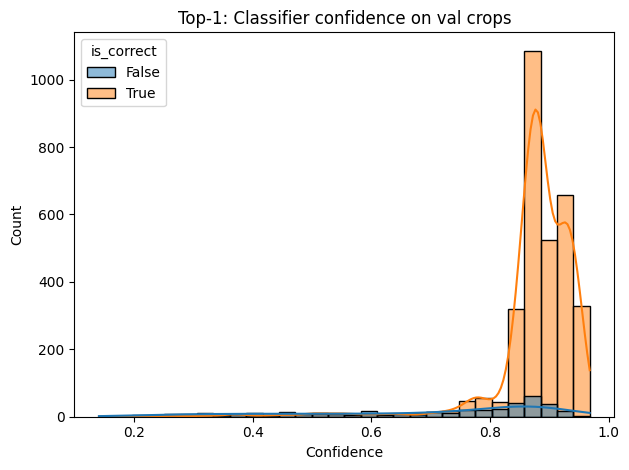

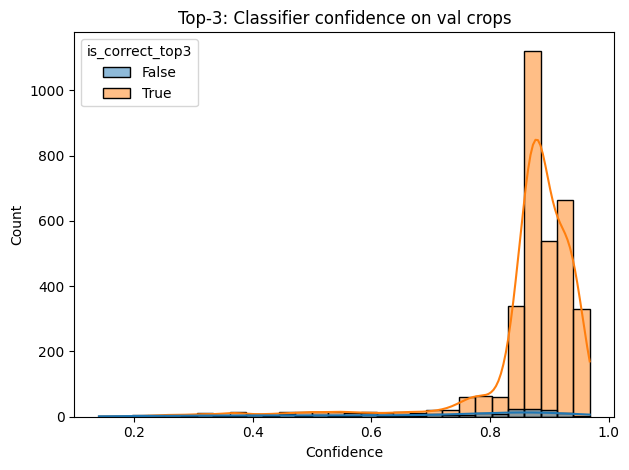

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged predictions (must include top3 info)
df = pd.read_csv("val_cls_merged.csv")


# Compute correctness
df["is_correct"] = df["true_class"] == df["pred_class"]

# --- Per-class Top-1 summary
per_class_top1 = df.groupby(["true_class", "is_correct"])["confidence"].describe()
print("📊 Top-1 Confidence Stats:")
print(per_class_top1)

# --- Per-class Top-3 summary
per_class_top3 = df.groupby(["true_class", "is_correct_top3"])["confidence"].describe()
print("\n📊 Top-3 Confidence Stats:")
print(per_class_top3)

# --- Top-1 accuracy
top1_acc = df["is_correct"].mean()
top3_acc = df["is_correct_top3"].mean()
print(f"\n✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Top-3 Accuracy: {top3_acc:.4f}")

# --- False positives Top-1
fp = df[~df["is_correct"]]
fp_stats = fp.groupby("true_class")["confidence"].describe()
print("\n🛑 Top-1 False Prediction Confidence Stats:")
print(fp_stats)

# --- Histograms (Top-1)
sns.histplot(data=df, x="confidence", hue="is_correct", bins=30, kde=True)
plt.title("Top-1: Classifier confidence on val crops")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- Histograms (Top-3)
sns.histplot(data=df, x="confidence", hue="is_correct_top3", bins=30, kde=True)
plt.title("Top-3: Classifier confidence on val crops")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [14]:
from pathlib import Path
import pandas as pd

crop_dir = Path("../data/megadetector_crops/val")  # ← change this if different
records = []

for cls in sorted(os.listdir(crop_dir)):
    for img_path in (crop_dir / cls).glob("*.jpg"):
        records.append({
            "filename": img_path.name,
            "filepath": str(img_path),
            "true_label": cls
        })

df_gt = pd.DataFrame(records)
df_gt.to_csv("val_crop_index.csv", index=False)
print(f"Indexed {len(df_gt)} crops.")


Indexed 3638 crops.


In [1]:
import torch
from PIL import Image
import torch, timm, numpy as np, pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from datetime import datetime
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from timm.layers.cbam import CbamModule
from tqdm import tqdm
import os
from PIL import Image

class ConvNeXtClassifier(nn.Module):
    def __init__(self, n_cls, dropout=0.5):
        super().__init__()
        self.backbone = timm.create_model(
            "convnext_small", pretrained=False, features_only=True)
        feat = self.backbone.feature_info[-1]["num_chs"]
        self.pool = nn.AdaptiveAvgPool2d(1)

        # ← KEEP THE NAME “classifier”
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, 256),  nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, n_cls)
        )

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = self.pool(x)
        return self.classifier(x)


def load_ckpt(path, arch_cls):
    ckpt = torch.load(path, map_location="cpu")
    classes = ckpt["class_names"]
    net = arch_cls(len(classes)); net.load_state_dict(ckpt["model_state_dict"])
    return net.eval().cuda(), classes



ckpt_path = "../scripts/train/convnext_classaware_finetuned/best_model.pth"
model, class_names = load_ckpt(ckpt_path, ConvNeXtClassifier)
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def classify_crop(img_path, model, tfm, idx_to_class):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).cuda()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze()
    conf, pred_idx = torch.max(probs, dim=0)
    return idx_to_class[pred_idx.item()], conf.item()


c:\Users\cilek\anaconda3\envs\pytorch-wildlife\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\cilek\AppData\Local\Temp\ipykernel_68012\2710579759.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals

In [16]:
from tqdm import tqdm

df_gt = pd.read_csv("val_crop_index.csv")
predictions = []

for i, row in tqdm(df_gt.iterrows(), total=len(df_gt), desc="Classifying crops"):
    try:
        pred_class, conf = classify_crop(row["filepath"], model, tfm, idx_to_class)
    except Exception as e:
        pred_class, conf = "error", 0.0
        print(f"⚠️ Error on {row['filepath']}: {e}")
    predictions.append({
        "filename": row["filename"],
        "true_label": row["true_label"],
        "pred_class": pred_class,
        "conf": conf,
        "filepath": row["filepath"]
    })

df_preds = pd.DataFrame(predictions)
df_preds.to_csv("val_preds_with_conf.csv", index=False)


Classifying crops: 100%|██████████| 3638/3638 [01:21<00:00, 44.52it/s]


In [17]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load predictions
df = pd.read_csv("val_preds_with_conf.csv")

# Filter out true background-labeled crops
df_eval = df[df["true_label"] != "background"].copy()

# Drop prediction errors
df_eval = df_eval[df_eval["pred_class"] != "error"]

# Metrics
y_true = df_eval["true_label"]
y_pred = df_eval["pred_class"]

print("✅ Accuracy (no threshold):", accuracy_score(y_true, y_pred))
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))


✅ Accuracy (no threshold): 0.9239835002946376

✅ Classification Report:
              precision    recall  f1-score   support

      badger      0.000     0.000     0.000         2
        bird      0.921     0.891     0.906        92
      bobcat      0.970     0.905     0.937       759
         cat      0.751     0.891     0.815       230
      coyote      0.906     0.931     0.919       321
        deer      0.947     0.900     0.923        20
         dog      0.887     0.861     0.874       173
     opossum      0.969     0.958     0.964       720
      rabbit      0.914     0.954     0.933       366
     raccoon      0.953     0.921     0.937       242
      rodent      0.852     0.836     0.844        55
       skunk      1.000     0.909     0.952        66
    squirrel      0.899     0.943     0.920       348

    accuracy                          0.924      3394
   macro avg      0.844     0.839     0.840      3394
weighted avg      0.927     0.924     0.925      3394



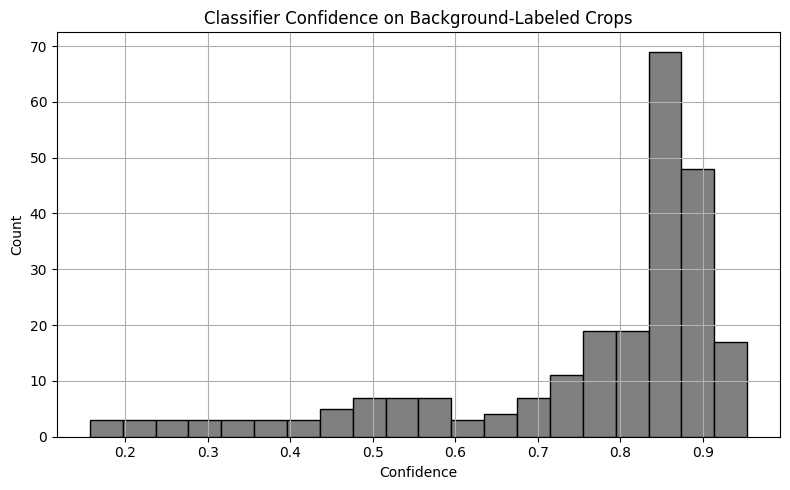

Total background-labeled crops: 244


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("val_preds_with_conf.csv")
df_bg = df[df["true_label"] == "background"].copy()
df_bg = df_bg[df_bg["pred_class"] != "error"]

plt.figure(figsize=(8, 5))
plt.hist(df_bg["conf"], bins=20, color="gray", edgecolor="black")
plt.title("Classifier Confidence on Background-Labeled Crops")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total background-labeled crops: {len(df_bg)}")


 Showing 152 crops — High Confidence (0.8–1.0)


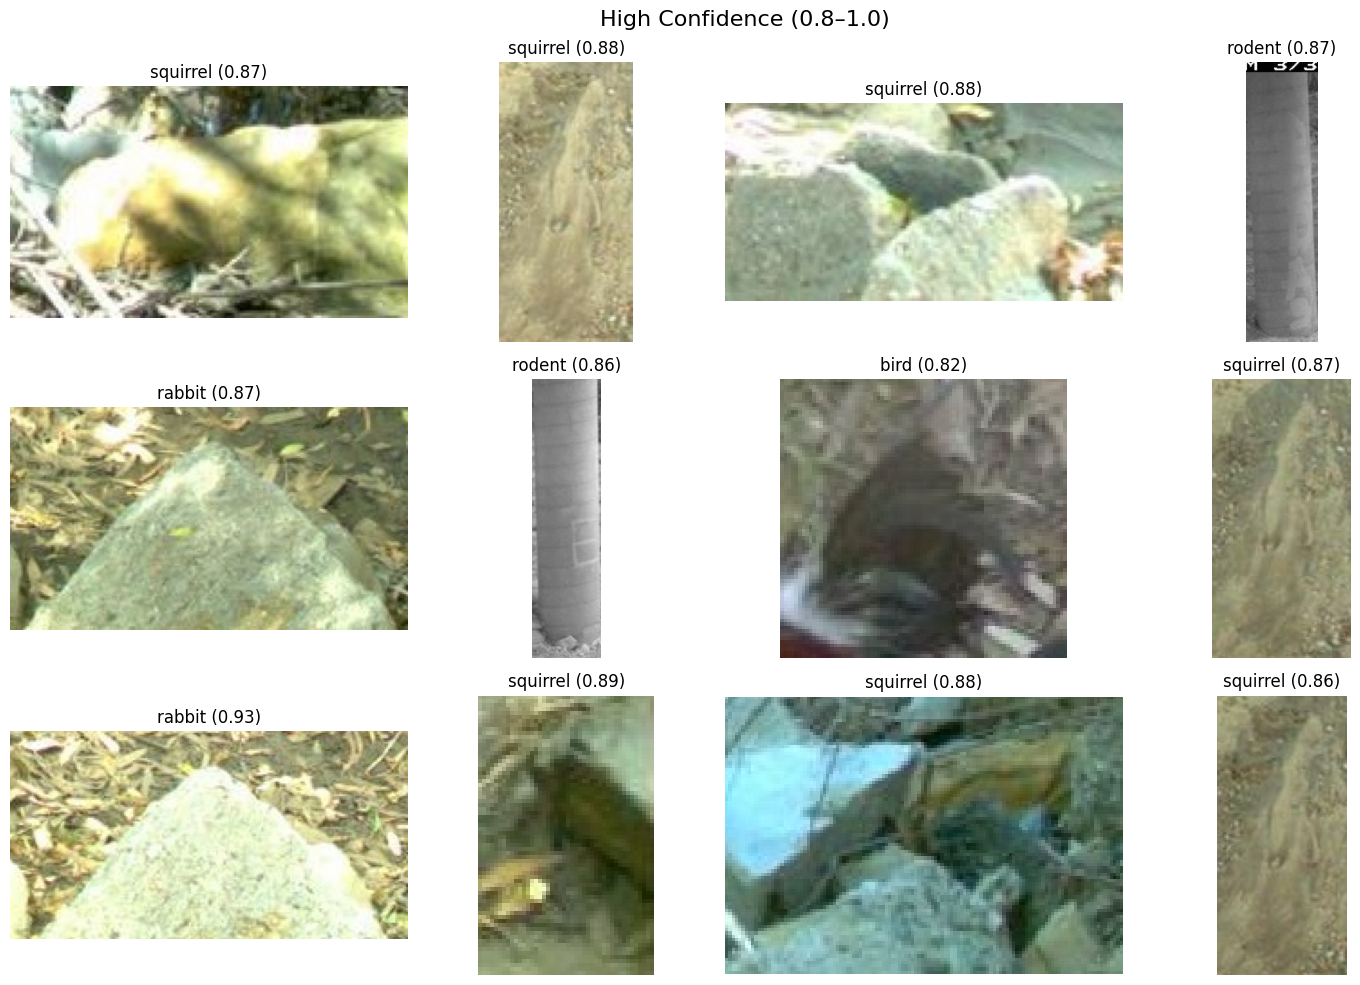

 Showing 64 crops — Medium Confidence (0.5–0.8)


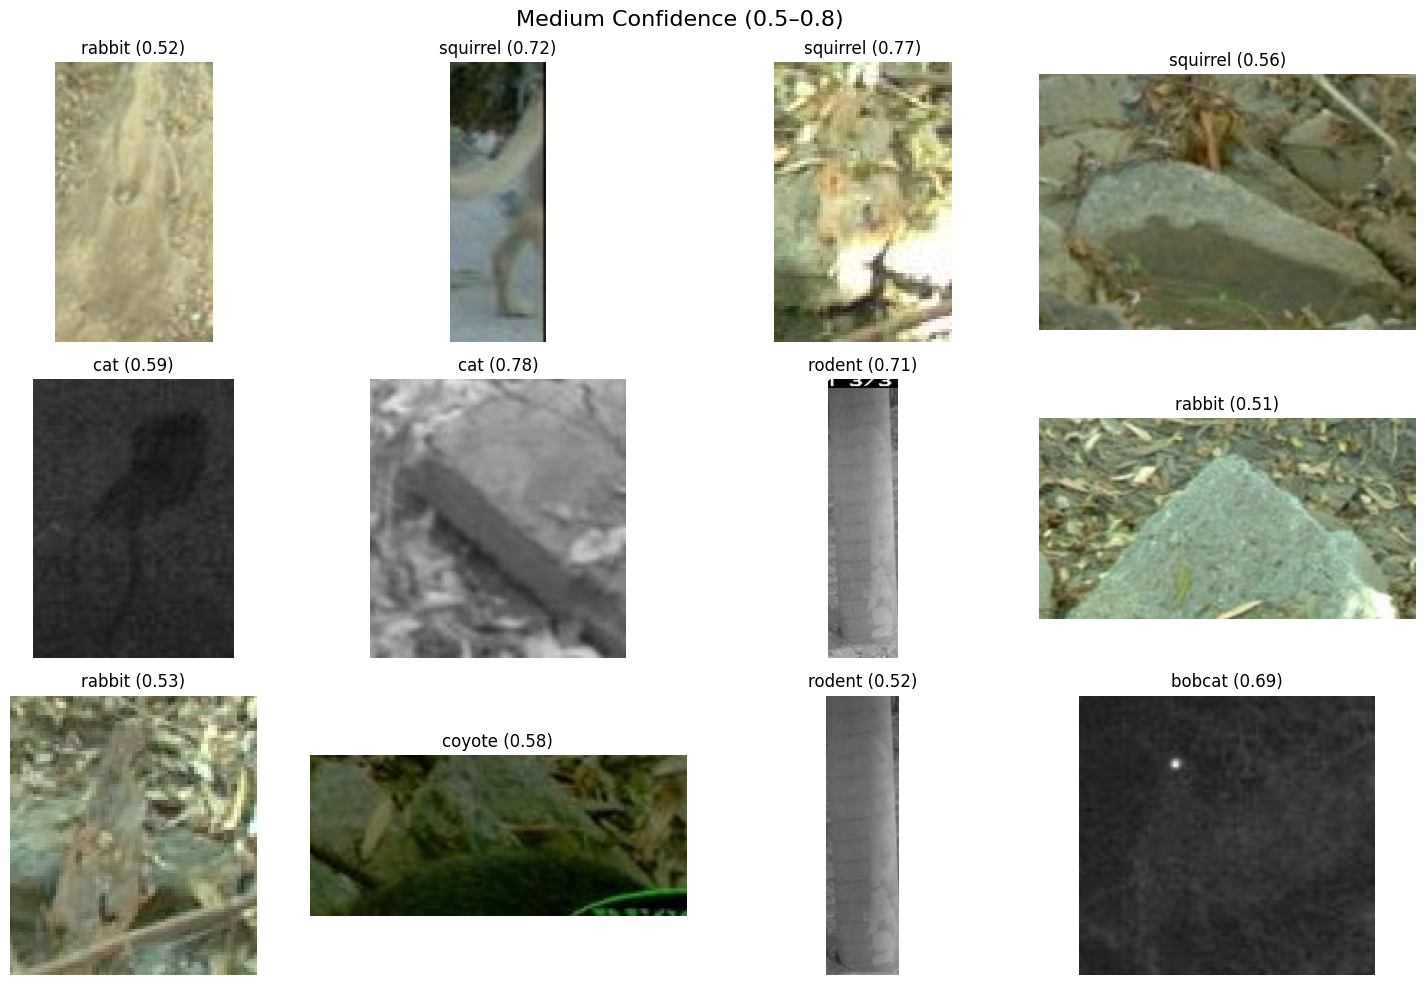

 Showing 28 crops — Low Confidence (0.0–0.5)


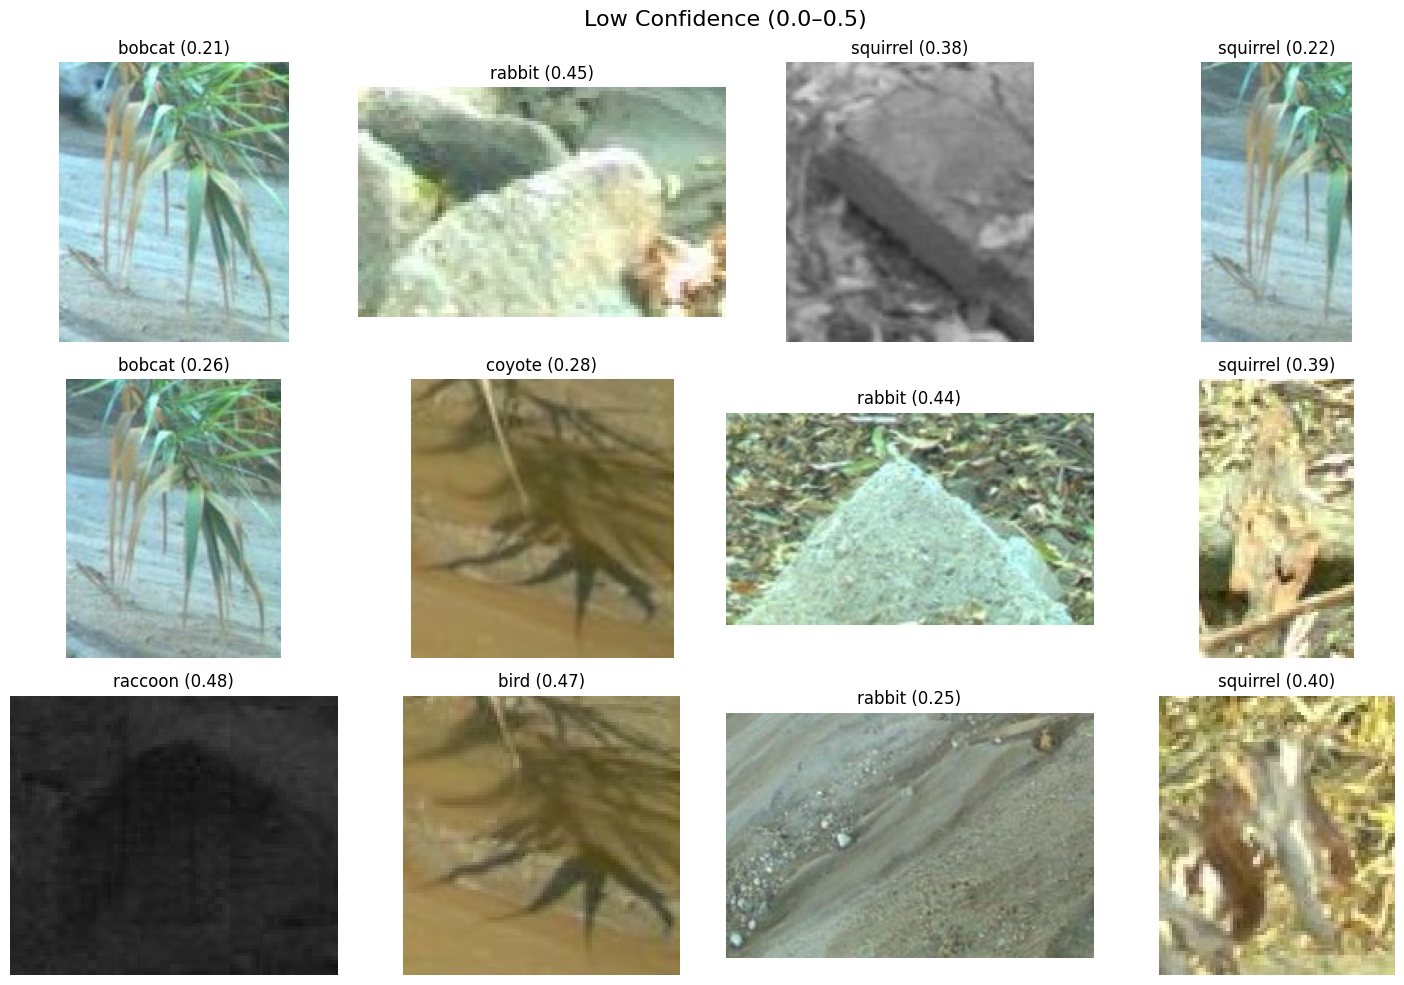

In [ ]:

from matplotlib import pyplot as plt

def show_bg_preds(df_bg_subset, title=""):
    print(f" Showing {len(df_bg_subset)} crops — {title}")
    plt.figure(figsize=(15, 10))
    for i, (_, row) in enumerate(df_bg_subset.head(12).iterrows()):
        img = cv2.imread(row["filepath"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(f"{row['pred_class']} ({row['conf']:.2f})")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# High confidence (> 0.8) → probably real animal?
high_conf_df = df_bg[df_bg["conf"] > 0.8]
show_bg_preds(high_conf_df, title="High Confidence (0.8–1.0)")

# Medium confidence
med_conf_df = df_bg[(df_bg["conf"] > 0.5) & (df_bg["conf"] <= 0.8)]
show_bg_preds(med_conf_df, title="Medium Confidence (0.5–0.8)")

# Low confidence → maybe actual background
low_conf_df = df_bg[df_bg["conf"] <= 0.5]
show_bg_preds(low_conf_df, title="Low Confidence (0.0–0.5)")


In [39]:
from sklearn.metrics import classification_report, accuracy_score

df_all = pd.read_csv("val_preds_with_conf.csv")
df_all = df_all[df_all["pred_class"] != "error"].copy()

total = len(df_all)
print(f"\n Total classified crops: {total}")

# Define bins
bins = {
    "High (0.8–1.0)"   : df_all[df_all["conf"] > 0.8],
    "Mid (0.5–0.8)"    : df_all[(df_all["conf"] > 0.5) & (df_all["conf"] <= 0.8)],
    "Low (0.0–0.5)"    : df_all[df_all["conf"] <= 0.5],
}

for label, subset in bins.items():
    non_bg     = subset[subset["true_label"] != "background"]
    correct    = non_bg[non_bg["true_label"] == non_bg["pred_class"]]
    incorrect  = non_bg[non_bg["true_label"] != non_bg["pred_class"]]

    print(f"{label:18}: {len(subset):4} total | "
          f"{len(non_bg):4} with true species | "
          f" {len(correct):4} correct |  {len(incorrect):4} wrong")

print("\n Overall Classification Report (true species only):")
df_eval = df_all[df_all["true_label"] != "background"].copy()
print(classification_report(df_eval["true_label"], df_eval["pred_class"], digits=3, zero_division=0))

acc = accuracy_score(df_eval["true_label"], df_eval["pred_class"])
print(f" Overall Accuracy (excluding background): {acc:.4f}")



 Total classified crops: 3638
High (0.8–1.0)    : 3198 total | 3046 with true species |  2916 correct |   130 wrong
Mid (0.5–0.8)     :  327 total |  263 with true species |   185 correct |    78 wrong
Low (0.0–0.5)     :  113 total |   85 with true species |    35 correct |    50 wrong

 Overall Classification Report (true species only):
              precision    recall  f1-score   support

      badger      0.000     0.000     0.000         2
        bird      0.921     0.891     0.906        92
      bobcat      0.970     0.905     0.937       759
         cat      0.751     0.891     0.815       230
      coyote      0.906     0.931     0.919       321
        deer      0.947     0.900     0.923        20
         dog      0.887     0.861     0.874       173
     opossum      0.969     0.958     0.964       720
      rabbit      0.914     0.954     0.933       366
     raccoon      0.953     0.921     0.937       242
      rodent      0.852     0.836     0.844        55
       sk

In [45]:
from sklearn.metrics import classification_report, accuracy_score

# Set threshold once here
THRESH = 0.55

df = pd.read_csv("val_preds_with_conf.csv")
df = df[df["pred_class"] != "error"].copy()

# Apply threshold → predictions < THRESH become "background"
df["final_pred"] = df.apply(
    lambda row: row["pred_class"] if row["conf"] >= THRESH else "background", axis=1
)

# Only evaluate true-labeled species (exclude true background)
df_eval = df[df["true_label"] != "background"].copy()
print(f"\nTotal true-labeled species: {len(df_eval)}")

# Confidence bins based on original conf (not re-thresholded again)
bins = {
    "High (0.8–1.0)"   : df_eval[df_eval["conf"] > 0.8],
    "Mid (0.5–0.8)"    : df_eval[(df_eval["conf"] > 0.5) & (df_eval["conf"] <= 0.8)],
    "Low (0.0–0.5)"    : df_eval[df_eval["conf"] <= 0.5],
}

for label, subset in bins.items():
    pred = subset.copy()
    correct   = pred[pred["true_label"] == pred["final_pred"]]
    wrong     = pred[(pred["final_pred"] != "background") & (pred["true_label"] != pred["final_pred"])]
    rejected  = pred[pred["final_pred"] == "background"]

    print(f"{label:18}: {len(subset):4} total | "
          f"{len(correct):4} correct | {len(wrong):4} wrong | {len(rejected):4} rejected")

# Final report
df_filtered = df_eval[df_eval["final_pred"] != "background"].copy()

print("\nClassification Report after thresholding (excluding background-labeled crops):")
print(classification_report(df_filtered["true_label"], df_filtered["final_pred"], digits=3, zero_division=0))

acc = accuracy_score(df_filtered["true_label"], df_filtered["final_pred"])
print(f"Accuracy (after thresholding @ {THRESH}): {acc:.4f}")



Total true-labeled species: 3394
High (0.8–1.0)    : 3046 total | 2916 correct |  130 wrong |    0 rejected
Mid (0.5–0.8)     :  263 total |  170 correct |   65 wrong |   28 rejected
Low (0.0–0.5)     :   85 total |    0 correct |    0 wrong |   85 rejected

Classification Report after thresholding (excluding background-labeled crops):
              precision    recall  f1-score   support

      badger      0.000     0.000     0.000         1
        bird      0.930     0.920     0.925        87
      bobcat      0.980     0.933     0.956       719
         cat      0.798     0.897     0.845       224
      coyote      0.927     0.958     0.942       307
        deer      1.000     0.909     0.952        11
         dog      0.908     0.892     0.900       166
     opossum      0.970     0.965     0.968       711
      rabbit      0.938     0.967     0.952       360
     raccoon      0.969     0.937     0.953       237
      rodent      0.885     0.852     0.868        54
       skunk

In [2]:
model, class_names = load_ckpt(ckpt_path, ConvNeXtClassifier)
model.eval().cuda()

# Dummy input for export
dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Output path
out_path = Path("../models/convnext_classifier.onnx")
out_path.parent.mkdir(parents=True, exist_ok=True)

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    out_path.as_posix(),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    export_params=True,
    opset_version=11,
    verbose=False
)

C:\Users\cilek\AppData\Local\Temp\ipykernel_68012\2710579759.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")
